# Convirtiendo la reflctibilidad a precipitación

La reflectivilidad $(Z)$ y la tasa de precipitación $(R)$ pueden ser relacionados usando una relación de potencias  $Z = a\cdot R^b$. Los parámetros $a, b$ depenenden del tipo de precipitación (por ejemplo del tamaño de la gota y la temperatura del agua). Wradlib proviciona un par de funcione que pueden ser útilies para este trabajo.

El siguiente ejemplo muestra los pasos para combertir de <a href="https://en.wikipedia.org/wiki/DBZ_(meteorology)">$dBZ$</a> (decibles de la reflectivilidad del factor Z) a la intenciad de la precipitación (en mm/h). 

In [1]:
import numpy as np
import wradlib as wl
import pylab as pl

In [2]:
dBZ = np.array([20,30,40,45,50,55])
print(dBZ)

[20 30 40 45 50 55]


In [3]:
#Convirtiendo a Z (mm^6/m^3)
Z = wl.trafo.idecibel(dBZ)
print(Z)

[1.00000000e+02 1.00000000e+03 1.00000000e+04 3.16227766e+04
 1.00000000e+05 3.16227766e+05]


In [4]:
# Convirtiendo a R (mm/h)
R = wl.zr.z_to_r(Z,a=200,b=1.6)
print(np.round(R,2))

[ 0.65  2.73 11.53 23.68 48.62 99.85]


In [5]:
#Conviritendo a volumen (mm = L/m^2). Depth.
V = wl.trafo.r_to_depth(R,300)
print(np.round(V,2))

[0.05 0.23 0.96 1.97 4.05 8.32]


## Un ejemplo con datos reales

Los datos del siguiente ejemplo contienen información de un radar del tipo DWD banda-C, instalado en Feldber, Alemania (SW-Germany). La figura muestra la acumulación de la precipitación en un intervalo de 15 minutos, producido por el escaneo de tres radares consecutivos en intervalos de 5 minutos entre las 17:30 y las 17:45 en junio 8, 2008

Los datos del radar son leidos usando la función <text style="color:blue;">wradlib.io.read_dx</text> la cual regresa un array de valores dBZ y un metadiccionario. Se realiza una converción de vaores a $V$ y se genera una gráfica del resultado.

In [6]:
def read_data(dtimes,path):
    """
        Función que facilita la lectura de datos
        
        Inputs
        ------
        dtimes:list
            Nombre del conjunto de datos
            
        path:str
            Ubicación de la carpeta de ejemplos        
        
        Outputs
        -------
        data:numpy.array
            Conjunto de datos en formato dBZ
    """
    data = np.empty((len(dtimes),360,128))
    dic = list(range(len(dtimes)))
    for i, dtime in enumerate(dtimes):
        f = path+'dx/raa00-dx_10908-{0}-fbg---bin.gz'.format(dtime)
        data[i], dic[i] = wl.io.read_dx(f)
    return(data,dic)

In [7]:
# Read
dtimes = ["0806021735","0806021740","0806021745"]
path = "/home/aceron/Documentos/GitHub/Tesis/wradlib-data-master/"
dBZ,metaDic = read_data(dtimes,path)
Z = wl.trafo.idecibel(dBZ)
R = wl.zr.z_to_r(Z,a=200,b=1.6)
V = wl.trafo.r_to_depth(R,300)
acum = np.sum(V,axis=0)

<Figure size 720x576 with 0 Axes>

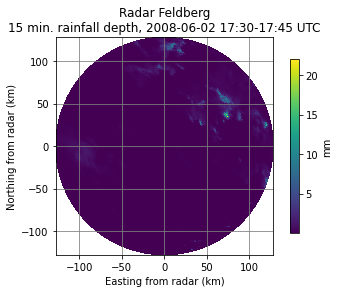

In [8]:
#Plot
pl.figure(figsize=(10,8))
ax, cf = wl.vis.plot_ppi(acum, cmap="viridis")
pl.xlabel("Easting from radar (km)")
pl.ylabel("Northing from radar (km)")
pl.title("Radar Feldberg\n15 min. rainfall depth, 2008-06-02 17:30-17:45 UTC")
cb = pl.colorbar(cf, shrink=0.8)
cb.set_label("mm")
pl.xlim(-128,128)
pl.ylim(-128,128)
pl.grid(color="grey")

## Ejemplo 2

Lectura de datos de radar usando el método iris (Vaisala Sigmet Interactive Radar Information System)

In [9]:
import os

In [10]:
def list_data(path:str,iyear:int,imonth:int,iday:int,fyear:int,fmonth:int,fday:int):
    """
        Función que facilita la lectura en intervalos dados. 
        El archivo esta descrito de la siguiente forma
            
                    CATYYMMDDHHmmSS.EXT
        
    Inputs
    ------
    
    path:str
        Directorio donde se alojan los datos    
    iyear:int
        Año inicial
    imonth:int
        Mes inicial
    iday:
        Día inicial
    fyear:int
        Año final
    fmonth:int
        Mes final
    fday:
        Día final
    
    data:list
        Regresa un arreglo con los nombres de los archivos
    """
    ldata = os.listdir(path)
    iname = "CAT"+str(iyear)[2:]+str(imonth).zfill(2)+str(iday).zfill(2)
    fname = "CAT"+str(fyear)[2:]+str(fmonth).zfill(2)+str(fday).zfill(2)
    filtro = [data for data in ldata if data[:9] in [iname,fname]]
    return(filtro)

def read_data(path:str,filename:str):
    """
        Regresa la lectura de un archivo usando read iris
    """
    #to MB
    size = os.stat(path+filename).st_size / (1024 * 1024)
    try:
        return(wl.io.iris.read_iris(path+filename))
    except:
        return((filename,size))


In [11]:
path = "datos/OneDrive_3_1-3-2021/"
ldatos = list_data(path,2015,1,1,2015,1,1)
flag = True
while flag:
    for data in ldatos[:20]:
        dic = read_data(path,data)
        if (type(dic) is tuple):
            print(dic)
        else:
            flag = False
            break
    print("rof")
    flag = False
        

('CAT150101142045.RAW9JXX', 0.19921875)
('CAT150101145044.RAW9JZG', 0.205078125)
rof


In [17]:
# Read
dBZ = dic['data'][1]['sweep_data']['DB_DBZ']['data']
print(dBZ.shape)
Z = wl.trafo.idecibel(dBZ)
print(Z.shape)
R = wl.zr.z_to_r(Z,a=200,b=1.6)
print(R.shape)
V = wl.trafo.r_to_depth(R,390)
print(V.shape)
acum = np.sum(V,axis=0)

(360, 1201)
(360, 1201)
(360, 1201)
(360, 1201)


<Figure size 720x576 with 0 Axes>

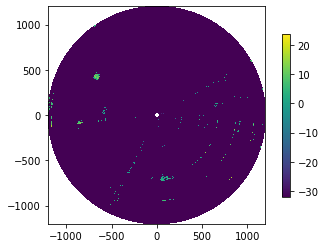

In [13]:
pl.figure(figsize=(10,8))
ax, pm = wl.vis.plot_ppi(dBZ)
cbar = pl.colorbar(pm, shrink=0.75)

In [18]:
Zc = np.multiply(dic['data'][1]['sweep_data']['DB_VEL']['data'],
                V)
print(Zc.shape)

(360, 1201)


<Figure size 720x720 with 0 Axes>

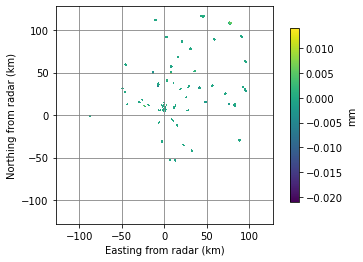

In [15]:
#Plot
pl.figure(figsize=(10,10))
ax, cf = wl.vis.plot_ppi(Zc)
pl.xlabel("Easting from radar (km)")
pl.ylabel("Northing from radar (km)")
cb = pl.colorbar(cf, shrink=0.8)
cb.set_label("mm")
pl.xlim(-128,128)
pl.ylim(-128,128)
pl.grid(color="grey")